In [2]:
class ReplicatingChromosome:
    """
    Represents a circular chromosome that can replicate bidirectionally from an origin.
    
    Initially, the chromosome has N beads (0 to N-1) in a circular arrangement.
    Replication starts at the origin (bead 0) and proceeds bidirectionally.
    """
    
    def __init__(self, initial_length, coords=None, box_size=(200.0, 200.0, 200.0)):
        """
        Initialize an unreplicated circular chromosome.
        
        Args:
            initial_length: Number of beads in the initial chromosome (e.g., 5000)
            coords: Optional dict mapping bead_id -> (x, y, z) tuple. If None, coordinates not initialized.
            box_size: Tuple of (x, y, z) box dimensions (default: (200.0, 200.0, 200.0))
        """
        self.initial_length = initial_length
        self.next_bead_id = initial_length  # Next available bead ID for new beads
        self.replicated_left = 0   # Number of beads replicated to the left (backwards from origin)
        self.replicated_right = 0  # Number of beads replicated to the right (forwards from origin)
        
        # Store bonds as a set of tuples (bead1, bead2) where bead1 < bead2
        self.bonds = set()
        
        # Initialize initial circular chromosome bonds
        for i in range(initial_length):
            next_bead = (i + 1) % initial_length
            if i < next_bead:
                self.bonds.add((i, next_bead))
            else:
                self.bonds.add((next_bead, i))
        
        # Coordinate storage: dict mapping bead_id -> (x, y, z) tuple
        self.coords = coords if coords is not None else {}
        self.box_size = box_size
        
        # Train track displacement: how much to displace daughter beads from mother
        self.daughter_displacement = 0.1  # Can be adjusted
    
    def get_left_fork_position(self):
        """Get the bead index of the left replication fork."""
        # After replicating n beads to the left, the fork is at position (initial_length - n)
        # For example, after 1 step, fork is at 4998 (which is 5000 - 1 - 1)
        return (self.initial_length - self.replicated_left - 1) % self.initial_length
    
    def get_right_fork_position(self):
        """Get the bead index of the right replication fork."""
        # After replicating n beads to the right, the fork is at position n
        # For example, after 1 step, fork is at 1
        return self.replicated_right
    
    def replicate_one_step(self):
        """
        Replicate one bead in both directions from the replication forks.
        
        Returns:
            tuple: (left_new_bead, right_new_bead) - IDs of the two new beads created
        """
        if self.is_fully_replicated():
            raise ValueError("Chromosome is already fully replicated")
        
        # Get current fork positions (before this replication step)
        # Initially (before any replication), both forks are at the origin (0)
        if self.replicated_left == 0 and self.replicated_right == 0:
            current_left_fork = 0
            current_right_fork = 0
        else:
            current_left_fork = self.get_left_fork_position()
            current_right_fork = self.get_right_fork_position()
        
        # Determine new fork positions (after this replication step)
        # For first step, forks start at origin (0) and move to positions 1 (right) and initial_length-2 (left)
        # For subsequent steps, forks move from current positions
        if self.replicated_left == 0 and self.replicated_right == 0:
            # First step: right fork goes to 1, left fork goes to initial_length - 2 (e.g., 8 for length 10)
            new_right_fork = 1
            new_left_fork = (self.initial_length - 2) % self.initial_length
        else:
            # Subsequent steps: right fork moves forward, left fork moves backward
            new_right_fork = (current_right_fork + 1) % self.initial_length
            new_left_fork = (current_left_fork - 1) % self.initial_length
        
        # Create two new beads for the right daughter strand
        left_new_bead = self.next_bead_id
        right_new_bead = self.next_bead_id + 1
        self.next_bead_id += 2
        
        # Check conditions before updating replication progress
        is_first_step = (self.replicated_left == 0 and self.replicated_right == 0)
        # Check if this will be the final step (after this step, total replicated will be current + 2)
        will_be_fully_replicated = (self.replicated_left + self.replicated_right + 2) >= self.initial_length
        
        # Handle bond updates
        if is_first_step:
            # First replication step: special case
            # After first step, we have:
            # Left daughter: ...8-9-0-1...
            # Right daughter: 10-11
            # Bonds: 8-10 (left fork to first right daughter), 10-11 (right daughter chain), 11-1 (right daughter to right fork)
            
            # Add bonds for first replication:
            # 1. Bond between the two new beads (right daughter): 10-11
            self.bonds.add(tuple(sorted([left_new_bead, right_new_bead])))
            
            # 2. Left fork connection: 8-10 (left fork at 8 connects to right daughter at 10)
            self.bonds.add(tuple(sorted([new_left_fork, left_new_bead])))
            
            # 3. Right fork connection: 11-1 (right daughter at 11 connects to right fork at 1)
            self.bonds.add(tuple(sorted([right_new_bead, new_right_fork])))
        elif not will_be_fully_replicated:
            # Subsequent replication steps (not the final step)
            # Get current rightmost right daughter bead (the previous right_new_bead, which is right_new_bead - 2)
            # Since we just created right_new_bead, the previous rightmost is right_new_bead - 2
            current_rightmost_right_daughter = right_new_bead - 2
            first_right_daughter_bead = self.initial_length  # e.g. 5000
            
            # Remove current fork bonds (that will be replaced):
            # 1. Remove the current bond between current rightmost right daughter and current right fork
            current_right_fork_bond = tuple(sorted([current_rightmost_right_daughter, current_right_fork]))
            self.bonds.discard(current_right_fork_bond)
            
            # 2. Remove the current left fork bond (5000 to current left fork)
            current_left_fork_bond = tuple(sorted([current_left_fork, first_right_daughter_bead]))
            self.bonds.discard(current_left_fork_bond)
            
            # Connect the right daughter chain (required bonds to extend the chain):
            # 1. Connect current rightmost to new left bead (extend right daughter chain: ...5001-5002...)
            self.bonds.add(tuple(sorted([current_rightmost_right_daughter, left_new_bead])))
            
            # 2. Connect the two new beads: left_new_bead - right_new_bead (5002-5003)
            self.bonds.add(tuple(sorted([left_new_bead, right_new_bead])))
            
            # Add 2 new fork connection bonds:
            # 1. New left fork connection: new_left_fork - 5000
            #    Bead 5000 (first right daughter bead) gets bonded to progressively smaller indices
            #    (e.g., 4998-5000 after step 1, 4997-5000 after step 2)
            self.bonds.add(tuple(sorted([new_left_fork, first_right_daughter_bead])))
            
            # 2. New right fork connection: right_new_bead - new_right_fork 
            #    (e.g., 5003-2 after step 2, connecting new rightmost right daughter to new right fork)
            self.bonds.add(tuple(sorted([right_new_bead, new_right_fork])))
        else:
            # Final replication step - both chromosomes become circular
            # Get current rightmost right daughter bead (the previous right_new_bead, which is right_new_bead - 2)
            print("Final replication step")
            current_rightmost_right_daughter = right_new_bead - 2
            first_right_daughter_bead = self.initial_length  # e.g. 5000
            
            # Remove current fork bonds (that will be replaced):
            # 1. Remove the current bond between current rightmost right daughter and current right fork
            current_right_fork_bond = tuple(sorted([current_rightmost_right_daughter, current_right_fork]))
            self.bonds.discard(current_right_fork_bond)
            
            # 2. Remove the current left fork bond (5000 to current left fork)
            current_left_fork_bond = tuple(sorted([current_left_fork, first_right_daughter_bead]))
            self.bonds.discard(current_left_fork_bond)
            
            # Connect the right daughter chain (required bonds to extend the chain):
            # 1. Connect current rightmost to new left bead (extend right daughter chain)
            self.bonds.add(tuple(sorted([current_rightmost_right_daughter, left_new_bead])))
            
            # 2. Connect the two new beads: left_new_bead - right_new_bead
            self.bonds.add(tuple(sorted([left_new_bead, right_new_bead])))
            
            # Close both circular chromosomes (no fork bonds needed):
            # 1. Close left daughter: connect new_left_fork to new_right_fork (completing the circle)
            self.bonds.add(tuple(sorted([new_left_fork, new_right_fork])))
            
            # 2. Close right daughter: connect right_new_bead to first_right_daughter_bead (completing the circle)
            self.bonds.add(tuple(sorted([right_new_bead, first_right_daughter_bead])))
        
        # Update replication progress
        self.replicated_left += 1
        self.replicated_right += 1
        
        # Update coordinates using train track model: daughter beads appear where mother beads were, but displaced slightly
        # Left new bead (from left fork): use coordinate from new_left_fork, displaced slightly
        if new_left_fork in self.coords:
            x, y, z = self.coords[new_left_fork]
            # Displace in a perpendicular direction (e.g., along z-axis)
            self.coords[left_new_bead] = (x, y, z + self.daughter_displacement)
        else:
            self.coords[left_new_bead] = (0.0, 0.0, self.daughter_displacement)
        
        # Right new bead (from right fork): use coordinate from new_right_fork, displaced slightly
        if new_right_fork in self.coords:
            x, y, z = self.coords[new_right_fork]
            # Displace in a perpendicular direction (e.g., along z-axis)
            self.coords[right_new_bead] = (x, y, z + self.daughter_displacement)
        else:
            self.coords[right_new_bead] = (0.0, 0.0, self.daughter_displacement)
        
        return (left_new_bead, right_new_bead)
    
    def is_fully_replicated(self):
        """
        Check if replication is complete (two separate circular chromosomes).
        
        Returns:
            bool: True if fully replicated
        """
        # Replication is complete when we've replicated half the chromosome in each direction
        return (self.replicated_left + self.replicated_right) >= self.initial_length
    
    def get_all_beads(self):
        """Get a list of all bead IDs."""
        # Original beads: 0 to initial_length-1
        # New beads: initial_length to next_bead_id-1
        total_beads = self.next_bead_id
        return list(range(total_beads))
    
    def get_bonds(self):
        """Get all bonds as a list of tuples."""
        return sorted(list(self.bonds))
    
    def load_coords_from_file(self, filename):
        """
        Load coordinates from a dna.q format file.
        
        Args:
            filename: Path to dna.q file
        """
        with open(filename, 'r') as f:
            lines = f.readlines()
        
        # Parse box size (first line)
        if len(lines) > 0:
            box_values = list(map(float, lines[0].split()))
            if len(box_values) >= 3:
                self.box_size = tuple(box_values[:3])
        
        # Parse number of beads (second line)
        num_beads = int(lines[1].strip()) if len(lines) > 1 else 0
        
        # Parse coordinates (lines 2 to num_beads+1)
        self.coords = {}
        for i in range(num_beads):
            if i + 2 < len(lines):
                parts = lines[i + 2].split()
                if len(parts) >= 4:
                    bead_id = int(parts[0])
                    x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                    self.coords[bead_id] = (x, y, z)
        
        # Ensure we have coordinates for all initial beads
        for i in range(self.initial_length):
            if i not in self.coords:
                # Default to origin if not specified
                self.coords[i] = (0.0, 0.0, 0.0)
    
    def write_coords_to_file(self, filename):
        """
        Write coordinates to a dna.q format file.
        
        Args:
            filename: Path to output dna.q file
        """
        all_beads = sorted(self.get_all_beads())
        
        with open(filename, 'w') as f:
            # Write box size
            f.write(f"{self.box_size[0]:.10f}   {self.box_size[1]:.10f}   {self.box_size[2]:.10f}\n")
            
            # Write number of beads
            f.write(f"{len(all_beads)}\n")
            
            # Write coordinates for each bead
            for bead_id in all_beads:
                if bead_id in self.coords:
                    x, y, z = self.coords[bead_id]
                    f.write(f"{bead_id}   {x:.10f}   {y:.10f}   {z:.10f}  0\n")
                else:
                    # Default to origin if coordinate not set
                    f.write(f"{bead_id}   0.0000000000   0.0000000000   0.0000000000  0\n")
            
            # Write terminator
            f.write("0\n")
    
    def visualize_state(self):
        """Print current state for debugging."""
        print(f"Initial length: {self.initial_length}")
        print(f"Replicated left: {self.replicated_left}, Replicated right: {self.replicated_right}")
        print(f"Left fork at: {self.get_left_fork_position()}, Right fork at: {self.get_right_fork_position()}")
        print(f"Total beads: {len(self.get_all_beads())}")
        print(f"Total bonds: {len(self.bonds)}")
        print(f"Bonds: {self.get_bonds()[:10]}..." if len(self.bonds) > 10 else f"Bonds: {self.get_bonds()}")


In [47]:
# Print all bonds at each step until replication is complete
test_length = 10
chromo = ReplicatingChromosome(test_length)

print("Initial state (before replication):")
print(f"Bonds: {chromo.get_bonds()}")
print()

step = 0
while not chromo.is_fully_replicated():
    step += 1
    left_new, right_new = chromo.replicate_one_step()
    print(f"After step {step} (created beads {left_new}, {right_new}):")
    print(f"Bonds: {chromo.get_bonds()}")
    print()

print("Replication complete!")
print(f"Final bonds: {chromo.get_bonds()}")


Initial state (before replication):
Bonds: [(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]

After step 1 (created beads 10, 11):
Bonds: [(0, 1), (0, 9), (1, 2), (1, 11), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (8, 10), (10, 11)]

After step 2 (created beads 12, 13):
Bonds: [(0, 1), (0, 9), (1, 2), (2, 3), (2, 13), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (7, 10), (8, 9), (10, 11), (11, 12), (12, 13)]

After step 3 (created beads 14, 15):
Bonds: [(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (3, 15), (4, 5), (5, 6), (6, 7), (6, 10), (7, 8), (8, 9), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15)]

After step 4 (created beads 16, 17):
Bonds: [(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (4, 5), (4, 17), (5, 6), (5, 10), (6, 7), (7, 8), (8, 9), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17)]

Final replication step
After step 5 (created beads 18, 19):
Bonds: [(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),

In [3]:
import random
import numpy as np

class ReplicatingLoopingChromosome:
    """
    A replicating chromosome with SMC-mediated loop extrusion.
    Contains a ReplicatingChromosome for structural bonds and manages loop bonds.
    """
    
    def __init__(self, initial_length, num_smc=50, smc_width=1, 
                 basal_death_prob=0.000004, step_prob=1.0, 
                 stall_death_prob=0.00005, knockoff=0.9995, bypass=0.0005,
                 random_seed=None):
        """
        Initialize a replicating chromosome with loop extrusion.
        
        Args:
            initial_length: Initial chromosome length
            num_smc: Number of SMC complexes (loops)
            smc_width: Width of SMC occupancy (occupies pos-width to pos+width)
            basal_death_prob: Probability of loop dissociation per timestep
            step_prob: Probability of taking a step
            stall_death_prob: Probability of dissociation when stalled
            knockoff: Probability of knockoff vs bypass when blocked
            bypass: Probability of bypass vs knockoff when blocked
            random_seed: Random seed for reproducibility
        """
        # Initialize chromosome (coords can be loaded later if needed)
        self.chromo = ReplicatingChromosome(initial_length)
        self.initial_length = initial_length
        
        # Loop extrusion parameters
        self.num_smc = num_smc
        self.smc_width = smc_width
        self.basal_death_prob = basal_death_prob
        self.step_prob = step_prob
        self.stall_death_prob = stall_death_prob
        self.knockoff = knockoff
        self.bypass = bypass
        
        # Random number generator
        if random_seed is not None:
            random.seed(random_seed)
            np.random.seed(random_seed)
        
        # Loop data structures
        # Each loop has two anchors (loops1[i], loops2[i])
        # These are bead indices in the chromosome
        self.loops1 = [0] * num_smc  # Left anchor positions (bead indices)
        self.loops2 = [0] * num_smc  # Right anchor positions (bead indices)
        self.stalled1 = [0] * num_smc  # Is left anchor stalled?
        self.stalled2 = [0] * num_smc  # Is right anchor stalled?
        
        # Occupancy tracking: how many SMCs occupy each bead
        # Size: max number of beads (2 * initial_length when fully replicated)
        max_beads = 2 * initial_length
        self.occupied = [0] * (max_beads + 1)
        
        # Track current max bead index (like N in C++ code)
        # This gets updated during replication, no need to query chromosome
        self.current_max_bead = initial_length - 1
        
        # Cache for performance
        self._beads_cache_invalid = True
        
        # Initialize loops by birthing them
        for i in range(num_smc):
            self.birth(i)
    
    def get_all_beads(self):
        """Get all bead indices in the chromosome."""
        return self.chromo.get_all_beads()
    
    def wrapped_index(self, idx):
        """Handle wraparound for bead indices. Uses current_max_bead (like N in C++)."""
        max_bead = self.current_max_bead
        if idx < 0:
            return max_bead + idx + 1
        if idx > max_bead:
            return idx - (max_bead + 1)
        return idx
    
    def occupy_around(self, pos):
        """Mark beads around position pos as occupied."""
        for j in range(-self.smc_width, self.smc_width + 1):
            wrapped_pos = self.wrapped_index(pos + j)
            if wrapped_pos < len(self.occupied):
                self.occupied[wrapped_pos] += 1
    
    def release_around(self, pos):
        """Release occupancy around position pos."""
        for j in range(-self.smc_width, self.smc_width + 1):
            wrapped_pos = self.wrapped_index(pos + j)
            if wrapped_pos < len(self.occupied):
                self.occupied[wrapped_pos] = max(0, self.occupied[wrapped_pos] - 1)
    
    def neighbors(self, pos):
        """Get occupancy values for neighbors around position pos. Optimized."""
        # Pre-allocate list
        width_range = 2 * self.smc_width + 1
        result = [0] * width_range
        for idx, j in enumerate(range(-self.smc_width, self.smc_width + 1)):
            wrapped_pos = self.wrapped_index(pos + j)
            if wrapped_pos < len(self.occupied):
                result[idx] = self.occupied[wrapped_pos]
        return result
    
    def is_empty_around(self, pos):
        """Check if area around position pos is empty. Optimized."""
        # Direct check without creating list
        for j in range(-self.smc_width, self.smc_width + 1):
            wrapped_pos = self.wrapped_index(pos + j)
            if wrapped_pos < len(self.occupied) and self.occupied[wrapped_pos] > 0:
                return False
        return True
    
    def _is_replication_in_progress(self):
        """Check if replication has started but not finished."""
        return (self.chromo.replicated_left > 0 or self.chromo.replicated_right > 0) and not self.chromo.is_fully_replicated()
    
    def no_forks_around(self, pos):
        """Check if replication forks are not near position pos. Optimized."""
        # If replication hasn't started or is complete, no forks to block
        if not self._is_replication_in_progress():
            return True
        
        left_fork = self.chromo.get_left_fork_position()
        right_fork = self.chromo.get_right_fork_position()
        
        for j in range(-self.smc_width, self.smc_width + 1):
            wrapped_pos = self.wrapped_index(pos + j)
            if wrapped_pos == left_fork or wrapped_pos == right_fork:
                return False
        return True
    
    def _get_cached_beads(self):
        """Get beads and cache them for performance."""
        if not hasattr(self, '_cached_beads') or self._beads_cache_invalid:
            self._cached_beads = self.get_all_beads()
            self._beads_cache_invalid = False
        return self._cached_beads
    
    def get_region_for_bead(self, bead_idx):
        """
        Determine which region a bead belongs to.
        Returns: 'left_daughter' or 'right_daughter'
        """
        if bead_idx < self.initial_length:
            return 'left_daughter'
        else:
            return 'right_daughter'
    
    def get_next_position(self, pos, direction):
        """
        Get next position based on chromosome topology.
        Uses current_max_bead instead of querying chromosome.
        direction: -1 for left anchor (moves left), +1 for right anchor (moves right)
        """
        if pos < self.initial_length:
            # Left daughter: circular, indices 0 to initial_length-1
            region_size = self.initial_length
            wrapped = (pos + direction) % region_size
            if wrapped < 0:
                wrapped += region_size
            return wrapped
        else:
            # Right daughter: linear during replication, circular when complete
            right_daughter_min = self.initial_length
            right_daughter_max = self.current_max_bead
            region_size = right_daughter_max - right_daughter_min + 1
            
            zero_based_pos = pos - right_daughter_min
            new_zero_based = zero_based_pos + direction
            
            if new_zero_based < 0:
                return pos  # Can't go before start
            if new_zero_based >= region_size:
                # Wrap around if fully replicated
                if self.chromo.is_fully_replicated():
                    print("fully replicated! wrapping around")
                    return right_daughter_min + (new_zero_based % region_size)
                else:
                    return pos  # Can't go after end if not fully replicated
            return right_daughter_min + new_zero_based
    
    def birth(self, i):
        """
        Create a new loop at random positions.
        Loops are created between two nearby beads.
        Uses current_max_bead instead of querying chromosome (like C++ code).
        """
        max_attempts = 1000
        spacing = 2 * self.smc_width + 1
        
        for attempt in range(max_attempts):
            # Pick a random position from 0 to current_max_bead (like C++: 1 to N)
            start_pos = random.randint(0, self.current_max_bead)
            
            if start_pos < self.initial_length:
                # Left daughter: circular topology
                idx1 = start_pos
                # Find idx2 that's spacing away, wrapping if needed
                idx2 = (idx1 + spacing) % self.initial_length
            else:
                # Right daughter: linear during replication
                idx1 = start_pos
                idx2 = idx1 + spacing
                # Check if idx2 is within valid range
                if idx2 > self.current_max_bead:
                    continue
            
            # Check if positions are valid
            if not (self.is_empty_around(idx1) and 
                    self.is_empty_around(idx2) and
                    self.no_forks_around(idx1) and
                    self.no_forks_around(idx2)):
                continue
            
            # Accept this position
            self.loops1[i] = idx1
            self.loops2[i] = idx2
            self.occupy_around(idx1)
            self.occupy_around(idx2)
            self.stalled1[i] = 0
            self.stalled2[i] = 0
            return
        
        # If we couldn't find a position after many attempts, leave as 0,0
        print(f"Warning: Could not find valid position for loop {i} after {max_attempts} attempts")
    
    def death(self):
        """Handle loop dissociation based on death probabilities."""
        for i in range(self.num_smc):
            if self.loops1[i] == 0 and self.loops2[i] == 0:
                continue  # Skip inactive loops
            
            # Calculate death probability based on stall state
            falloff1 = self.stall_death_prob if self.stalled1[i] else self.basal_death_prob
            falloff2 = self.stall_death_prob if self.stalled2[i] else self.basal_death_prob
            falloff_rate = max(falloff1, falloff2)
            
            if random.random() < falloff_rate:
                # Dissociate loop
                self.release_around(self.loops1[i])
                self.release_around(self.loops2[i])
                self.stalled1[i] = 0
                self.stalled2[i] = 0
                self.birth(i)  # Rebirth at new location
    
    def get_next_vacancy(self, pos, direction, max_search=15):
        """Find the next empty position in the given direction."""
        candidate = pos
        for _ in range(max_search):
            candidate = self.get_next_position(candidate, direction)
            if self.is_empty_around(candidate) and self.no_forks_around(candidate):
                return candidate
        return pos  # No vacancy found
    
    def step(self, tag_extruded=False):
        """
        Move loops by extruding (left anchor moves left, right anchor moves right).
        Optimized version.
        tag_extruded: whether to track extruded positions (not implemented yet)
        """
        # Cache fork positions for this step (they don't change during a step)
        # Only get fork positions if replication is in progress
        if self._is_replication_in_progress():
            left_fork = self.chromo.get_left_fork_position()
            right_fork = self.chromo.get_right_fork_position()
        else:
            left_fork = None
            right_fork = None
        
        for i in range(self.num_smc):
            if self.loops1[i] == 0 and self.loops2[i] == 0:
                continue  # Skip inactive loops
            
            cur1 = self.loops1[i]  # Left anchor
            cur2 = self.loops2[i]  # Right anchor
            
            # Reset stall flags
            self.stalled1[i] = 0
            self.stalled2[i] = 0
            
            # Move left anchor (direction -1)
            if random.random() <= self.step_prob:
                new_cur1 = self.get_next_position(cur1, -1)
                # Check only the leftmost neighbor (the new position we're moving into)
                # This matches C++ behavior: neighbors(newCur1).front() == 0
                wrapped_pos = self.wrapped_index(new_cur1 - self.smc_width)
                leftmost_neighbor_empty = (wrapped_pos >= len(self.occupied) or self.occupied[wrapped_pos] == 0)
                
                # Check if forks are nearby (forks block SMCs only during active replication)
                no_forks = self._no_forks_at_pos(new_cur1, left_fork, right_fork)
                
                if leftmost_neighbor_empty and no_forks:
                    # Take normal step
                    self.occupy_around(new_cur1)
                    self.release_around(cur1)
                    self.loops1[i] = new_cur1
                else:
                    # Blocked - try bypass or stall
                    # If blocked by fork, always stall
                    if not no_forks:
                        self.stalled1[i] = 1
                    else:
                        rate_sum = self.knockoff + self.bypass
                        if random.random() <= rate_sum:
                            if new_cur1 < len(self.occupied) and self.occupied[new_cur1] > 2:
                                # Stall
                                self.stalled1[i] = 1
                            elif random.random() <= self.knockoff / rate_sum:
                                # Stall
                                self.stalled1[i] = 1
                            else:
                                # Bypass
                                new_cur1 = self.get_next_vacancy(cur1, -1)
                                self.occupy_around(new_cur1)
                                self.release_around(cur1)
                                self.loops1[i] = new_cur1
            
            # Move right anchor (direction +1)
            if random.random() <= self.step_prob:
                new_cur2 = self.get_next_position(cur2, 1)
                # Check only the rightmost neighbor (the new position we're moving into)
                # This matches C++ behavior: neighbors(newCur2).back() == 0
                wrapped_pos = self.wrapped_index(new_cur2 + self.smc_width)
                rightmost_neighbor_empty = (wrapped_pos >= len(self.occupied) or self.occupied[wrapped_pos] == 0)
                
                # Check if forks are nearby (forks block SMCs only during active replication)
                no_forks = self._no_forks_at_pos(new_cur2, left_fork, right_fork)
                
                if rightmost_neighbor_empty and no_forks:
                    # Take normal step
                    self.occupy_around(new_cur2)
                    self.release_around(cur2)
                    self.loops2[i] = new_cur2
                else:
                    # Blocked - try bypass or stall
                    # If blocked by fork, always stall
                    if not no_forks:
                        self.stalled2[i] = 1
                    else:
                        rate_sum = self.knockoff + self.bypass
                        if random.random() <= rate_sum:
                            if new_cur2 < len(self.occupied) and self.occupied[new_cur2] > 2:
                                # Stall
                                self.stalled2[i] = 1
                            elif random.random() <= self.knockoff / rate_sum:
                                # Stall
                                self.stalled2[i] = 1
                            else:
                                # Bypass
                                new_cur2 = self.get_next_vacancy(cur2, 1)
                                self.occupy_around(new_cur2)
                                self.release_around(cur2)
                                self.loops2[i] = new_cur2
    
    def _no_forks_at_pos(self, pos, left_fork, right_fork):
        """Check if position is not near either fork. Uses _is_pos_near_fork."""
        # If replication hasn't started or is complete, no forks to block
        if not self._is_replication_in_progress() or left_fork is None or right_fork is None:
            return True
        return not (self._is_pos_near_fork(pos, left_fork) or self._is_pos_near_fork(pos, right_fork))
    
    def get_loop_bonds(self):
        """
        Get all loop bonds as a list of tuples (bead1, bead2).
        These represent the connections between loop anchors.
        """
        loop_bonds = []
        for i in range(self.num_smc):
            if self.loops1[i] != 0 or self.loops2[i] != 0:  # Active loop
                bond = tuple(sorted([self.loops1[i], self.loops2[i]]))
                loop_bonds.append(bond)
        return loop_bonds
    
    def get_all_bonds(self):
        """
        Get all bonds: structural bonds from chromosome + loop bonds.
        Returns a list of tuples (bead1, bead2) where bead1 < bead2.
        """
        all_bonds = set(self.chromo.get_bonds())  # Structural bonds
        loop_bonds = self.get_loop_bonds()
        all_bonds.update(loop_bonds)  # Add loop bonds
        return sorted(list(all_bonds))
    
    def write_bonds_to_file(self, filename, k_stretch=1000, l0=0.472, k_angle=3, theta0=0):
        """
        Write bonds to file in dna_bonds format.
        Structural bonds come first, then SMC bonds (annotated with ;SMC).
        
        Args:
            filename: Path to output bonds file
            k_stretch: Stretch constant (default: 1000)
            l0: Equilibrium bond length (default: 0.472)
            k_angle: Angle constant (default: 3)
            theta0: Equilibrium angle (default: 0)
        """
        structural_bonds = self.chromo.get_bonds()
        smc_bonds = self.get_loop_bonds()
        
        with open(filename, 'w') as f:
            # Write header
            f.write("; DNA bonds file (generated by dts_generate)\n")
            f.write("; Global bond parameters:\n")
            f.write(f"; k_stretch = {k_stretch}\n")
            f.write(f"; l0 = {l0}\n")
            f.write(f"; k_angle = {k_angle}\n")
            f.write(f"; theta0 = {theta0}\n")
            f.write("; Number of chains: 2\n")
            f.write("; Format: v1 v2 [k_stretch] [l0] (if k_stretch and l0 are in header, only v1 v2 needed)\n")
            f.write("\n")
            
            # Write structural bonds
            for bond in structural_bonds:
                bead1, bead2 = bond
                f.write(f"{bead1} {bead2}\n")
            
            # Write SMC bonds (annotated with ;SMC)
            for bond in smc_bonds:
                bead1, bead2 = bond
                f.write(f"{bead1} {bead2} ;SMC\n")
    
    def load_coords_from_file(self, filename):
        """Load coordinates from dna.q file (delegates to chromosome)."""
        self.chromo.load_coords_from_file(filename)
    
    def write_coords_to_file(self, filename):
        """Write coordinates to dna.q file (delegates to chromosome)."""
        self.chromo.write_coords_to_file(filename)
    
    def _is_pos_near_fork(self, smc_pos, fork_pos):
        """Check if SMC position is within smc_width of fork position (considering topology)."""
        # Check all positions within smc_width of the fork
        for j in range(-self.smc_width, self.smc_width + 1):
            fork_neighbor = self.wrapped_index(fork_pos + j)
            if fork_neighbor == smc_pos:
                return True
        return False
    
    def _push_off_smc_at_pos(self, pos):
        """
        Push off (dissociate) any SMC that has an anchor within smc_width of position pos.
        This handles the case where a replication fork moves through an SMC.
        Returns list of SMC indices that were pushed off.
        """
        pushed_off = []
        for i in range(self.num_smc):
            if self.loops1[i] == 0 and self.loops2[i] == 0:
                continue  # Skip inactive loops
            
            # Check if either anchor is within smc_width of the fork position
            pos1_near = self._is_pos_near_fork(self.loops1[i], pos)
            pos2_near = self._is_pos_near_fork(self.loops2[i], pos)
            
            if pos1_near or pos2_near:
                # This SMC is in the way of the fork - push it off
                self.release_around(self.loops1[i])
                self.release_around(self.loops2[i])
                self.stalled1[i] = 0
                self.stalled2[i] = 0
                self.birth(i)  # Rebirth at new location
                pushed_off.append(i)
        return pushed_off
    
    def replicate_one_step(self):
        """
        Replicate the chromosome one step.
        Pushes off SMCs that are in the way of moving forks.
        """
        # Get old fork positions before replication
        old_left_fork = self.chromo.get_left_fork_position()
        old_right_fork = self.chromo.get_right_fork_position()
        
        # Store old max_bead before replication (needed for proper re-indexing)
        old_max_bead = self.current_max_bead
        
        # Perform replication
        result = self.chromo.replicate_one_step()
        
        # Update current_max_bead (two new beads were created)
        # next_bead_id is the next available ID, so max is next_bead_id - 1
        self.current_max_bead = self.chromo.next_bead_id - 1
        
        # Get new fork positions after replication
        new_left_fork = self.chromo.get_left_fork_position()
        new_right_fork = self.chromo.get_right_fork_position()
        
        # Push off SMCs that are at the new fork positions
        pushed_off_left = self._push_off_smc_at_pos(new_left_fork)
        pushed_off_right = self._push_off_smc_at_pos(new_right_fork)
        
        # Push off SMCs that the forks passed through
        # Check positions between old and new fork positions
        if old_left_fork != new_left_fork:
            # Left fork moves backward (decreasing index, wrapping around)
            # Calculate path from old to new (backward direction)
            max_bead = self.current_max_bead
            if old_left_fork > new_left_fork:
                # Simple backward movement, no wraparound
                for pos in range(new_left_fork, old_left_fork + 1):
                    self._push_off_smc_at_pos(pos)
            else:
                # Wraparound: from old_left_fork backward to 0, then to new_left_fork
                for pos in range(old_left_fork, max_bead + 1):
                    self._push_off_smc_at_pos(pos)
                for pos in range(0, new_left_fork + 1):
                    self._push_off_smc_at_pos(pos)
        
        if old_right_fork != new_right_fork:
            # Right fork moves forward (increasing index)
            # Simple forward movement
            max_bead = self.current_max_bead
            if new_right_fork > old_right_fork:
                for pos in range(old_right_fork, new_right_fork + 1):
                    self._push_off_smc_at_pos(pos)
            else:
                # Shouldn't happen, but handle wraparound case
                for pos in range(old_right_fork, max_bead + 1):
                    self._push_off_smc_at_pos(pos)
                for pos in range(0, new_right_fork + 1):
                    self._push_off_smc_at_pos(pos)
        
        # Re-index SMCs on the right daughter (shift by +1)
        # This matches C++ behavior: loops1[i] = loops1[i] + (N_new - N_old) / 2
        # For each replication step, N increases by 2, so shift is 1
        for i in range(self.num_smc):
            if self.loops1[i] == 0 and self.loops2[i] == 0:
                continue  # Skip inactive loops
            
            # Check if both anchors are on the right daughter
            if self.loops1[i] >= self.initial_length and self.loops2[i] >= self.initial_length:
                # Shift both anchors by +1 (re-indexing)
                self.loops1[i] = self.loops1[i] + 1
                self.loops2[i] = self.loops2[i] + 1
        
        # Rebuild occupied array from scratch (cleanest approach after re-indexing)
        # This avoids issues with wraparound behavior changing when max_bead changes
        max_beads = 2 * self.initial_length
        self.occupied = [0] * (max_beads + 1)
        
        # Re-add occupancy from all current SMC positions
        for i in range(self.num_smc):
            if self.loops1[i] != 0 or self.loops2[i] != 0:
                self.occupy_around(self.loops1[i])
                self.occupy_around(self.loops2[i])
        
        # Invalidate cache when chromosome structure changes
        self._beads_cache_invalid = True
        return result
    
    def validate_occupied_array(self):
        """
        Sanity check: Verify that the occupied array matches actual SMC positions.
        Note: Forks are not tracked in the occupied array, only SMCs.
        Returns: (is_valid, error_messages)
        """
        errors = []
        
        # Recalculate what occupied should be (only from SMCs, not forks)
        expected_occupied = [0] * len(self.occupied)
        
        # Add occupancy from SMCs only
        for i in range(self.num_smc):
            if self.loops1[i] != 0 or self.loops2[i] != 0:
                for pos in [self.loops1[i], self.loops2[i]]:
                    for j in range(-self.smc_width, self.smc_width + 1):
                        wrapped_pos = self.wrapped_index(pos + j)
                        if wrapped_pos < len(expected_occupied):
                            expected_occupied[wrapped_pos] += 1
        
        # Compare with actual occupied array
        for pos in range(len(self.occupied)):
            if self.occupied[pos] != expected_occupied[pos]:
                errors.append(f"Position {pos}: expected {expected_occupied[pos]}, got {self.occupied[pos]}")
        
        is_valid = len(errors) == 0
        return (is_valid, errors)
    
    def validate_smc_positions(self):
        """
        Sanity check: Verify that SMCs are not in invalid positions.
        Invalid positions include:
        - SMCs spanning between left and right daughters
        - SMCs spanning between daughters and mother (during replication)
        
        Returns: (is_valid, error_messages)
        """
        errors = []
        all_beads = self.get_all_beads()
        if not all_beads:
            return (True, [])
        
        left_daughter_beads = set([b for b in all_beads if b < self.initial_length])
        right_daughter_beads = set([b for b in all_beads if b >= self.initial_length])
        
        for i in range(self.num_smc):
            if self.loops1[i] == 0 and self.loops2[i] == 0:
                continue  # Skip inactive loops
            
            pos1 = self.loops1[i]
            pos2 = self.loops2[i]
            
            # Check if SMC spans between daughters
            pos1_in_left = pos1 in left_daughter_beads
            pos1_in_right = pos1 in right_daughter_beads
            pos2_in_left = pos2 in left_daughter_beads
            pos2_in_right = pos2 in right_daughter_beads
            
            if (pos1_in_left and pos2_in_right) or (pos1_in_right and pos2_in_left):
                errors.append(f"SMC {i}: spans between daughters (pos1={pos1}, pos2={pos2})")
            
            # Check if positions are valid beads
            if pos1 not in all_beads:
                errors.append(f"SMC {i}: pos1={pos1} is not a valid bead")
            if pos2 not in all_beads:
                errors.append(f"SMC {i}: pos2={pos2} is not a valid bead")
        
        is_valid = len(errors) == 0
        return (is_valid, errors)
    
    def is_fully_replicated(self):
        """Check if replication is complete."""
        return self.chromo.is_fully_replicated()


In [133]:
# Test ReplicatingLoopingChromosome
print("Testing ReplicatingLoopingChromosome...")
print("=" * 60)

# Create a small chromosome with a few loops
test_chromo = ReplicatingLoopingChromosome(
    initial_length=5000, 
    num_smc=3, 
    smc_width=1,
    random_seed=42
)

print(f"\nInitial state:")
print(f"  All beads: {test_chromo.get_all_beads()}")
print(f"  Structural bonds: {len(test_chromo.chromo.get_bonds())}")
print(f"  Loop bonds: {test_chromo.get_loop_bonds()}")
print(f"  Total bonds: {len(test_chromo.get_all_bonds())}")
print(f"  Active loops: {sum(1 for i in range(test_chromo.num_smc) if test_chromo.loops1[i] != 0 or test_chromo.loops2[i] != 0)}")

# Run a few steps
print(f"\nRunning 10 loop extrusion steps...")
for i in range(10):
    test_chromo.death()
    test_chromo.step()

print(f"  Loop bonds after steps: {test_chromo.get_loop_bonds()}")
print(f"  Total bonds: {len(test_chromo.get_all_bonds())}")

# Test replication
print(f"\nReplicating one step...")
test_chromo.replicate_one_step()
print(f"  All beads: {test_chromo.get_all_beads()}")
print(f"  Structural bonds: {len(test_chromo.chromo.get_bonds())}")
print(f"  Loop bonds: {test_chromo.get_loop_bonds()}")
print(f"  Total bonds: {len(test_chromo.get_all_bonds())}")

print(f"\n✓ Test complete!")


Testing ReplicatingLoopingChromosome...

Initial state:
  All beads: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_arc_diagram(chromo, title="Loop Arc Diagram", figsize=(15, 6)):
    """
    Plot an arc diagram showing the chromosome and loops.
    Optimized version with circular arcs.
    
    Args:
        chromo: ReplicatingLoopingChromosome object
        title: Plot title
        figsize: Figure size (width, height)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    all_beads = chromo.get_all_beads()
    if not all_beads:
        ax.text(0.5, 0.5, "No beads", ha='center', va='center', transform=ax.transAxes)
        plt.title(title)
        return fig
    
    beads_set = set(all_beads)
    all_beads_array = np.array(all_beads)
    
    min_bead = all_beads_array.min()
    max_bead = all_beads_array.max()
    bead_range = max_bead - min_bead
    
    # Draw the chromosome as a horizontal line
    y_line = 0.1
    ax.plot([min_bead, max_bead], [y_line, y_line], 'k-', linewidth=2, label='Chromosome', zorder=1)
    
    # Batch plot all bead positions at once
    ax.plot(all_beads_array, [y_line] * len(all_beads_array), 'ko', markersize=4, zorder=2)
    
    # Mark replication forks
    left_fork = chromo.chromo.get_left_fork_position()
    right_fork = chromo.chromo.get_right_fork_position()
    
    if left_fork in beads_set:
        ax.plot(left_fork, y_line, 'rv', markersize=15, label='Left Fork', zorder=6)
    if right_fork in beads_set:
        ax.plot(right_fork, y_line, 'b^', markersize=15, label='Right Fork', zorder=6)
    
    # Mark the origin
    if 0 in beads_set:
        ax.plot(0, y_line, 'gs', markersize=15, label='Origin', zorder=6)
    
    # Collect active loops
    active_loops = []
    for i in range(chromo.num_smc):
        pos1, pos2 = chromo.loops1[i], chromo.loops2[i]
        if pos1 != 0 or pos2 != 0:
            if pos1 in beads_set and pos2 in beads_set:
                active_loops.append((pos1, pos2))
    
    # Sort loops by start position for layering
    active_loops.sort(key=lambda x: x[0])
    
    # Draw circular arcs (semicircles)
    # For proper semicircles, width == height (diameter = distance between points)
    anchor_positions_x = []
    anchor_positions_y = []
    
    for idx, (pos1, pos2) in enumerate(active_loops):
        center_x = (pos1 + pos2) / 2.0
        distance = abs(pos2 - pos1)
        
        # For a semicircle connecting two points, the diameter equals the distance
        # width == height creates a perfect circle, and the arc connects the points
        arc_diameter = distance
        
        # Create semicircular arc (width == height makes it circular)
        arc = mpatches.Arc(
            (center_x, y_line),
            arc_diameter,   # horizontal span (distance between points)
            1,   # vertical span (same as width for perfect circle)
            angle=0,
            theta1=0,
            theta2=180,
            linewidth=1.5,
            color='red',
            alpha=0.6,
            zorder=3 + idx
        )
        ax.add_patch(arc)
        
        # Collect anchor points for batch plotting
        anchor_positions_x.extend([pos1, pos2])
        anchor_positions_y.extend([y_line, y_line])
    
    # Batch plot anchor points
    if anchor_positions_x:
        ax.plot(anchor_positions_x, anchor_positions_y, 'ro', markersize=5, zorder=4)
    
    # Add region labels
    ax.axvline(x=chromo.initial_length - 0.5, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.text(chromo.initial_length / 2, -0.15, 'Left Daughter', ha='center', fontsize=9, color='gray')
    
    if max_bead >= chromo.initial_length:
        right_center = (chromo.initial_length + max_bead) / 2
        ax.text(right_center, -0.15, 'Right Daughter', ha='center', fontsize=9, color='gray')
    
    # Set labels and title
    ax.set_xlabel('Bead Index', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Calculate y-limits to accommodate arcs (arcs can go up to distance/2 above the line)
    # Always include negative space for markers
    if active_loops:
        # Calculate max arc height from active loops
        max_arc_height = max([abs(p2 - p1) / 2.0 for p1, p2 in active_loops])
        # Cap arc height to prevent extremely tall arcs
        max_arc_height = min(max_arc_height, 2.0)  # Cap at reasonable height
        max_arc_height = max(max_arc_height, 0.3)  # Minimum for visibility
    else:
        # Default arc height when no loops
        max_arc_height = 0.3
    
    # Set fixed y-limits with negative space for markers
    y_min = -0.4  # Ensure negative space for markers (beads, forks, origin, labels)
    y_max = y_line + max_arc_height + 0.3  # Room for arcs above the line plus padding
    y_max = max(y_max, 0.8)  # Ensure minimum height for visibility
    
    # Disable autoscaling on y-axis to prevent matplotlib from overriding our limits
    ax.set_autoscaley_on(False)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(min_bead - bead_range * 0.05, max_bead + bead_range * 0.05)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9)
    
    # Add info text
    info_text = f"Active Loops: {len(active_loops)}/{chromo.num_smc}"
    if not chromo.chromo.is_fully_replicated():
        info_text += f" | Replicated: L={chromo.chromo.replicated_left}, R={chromo.chromo.replicated_right}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Re-set y-limits after tight_layout to ensure they're preserved
    ax.set_ylim(y_min, y_max)
    
    return fig

def plot_loop_evolution_sequence(chromo, num_steps=50, steps_per_frame=10, 
                                 include_replication=False, replication_steps=None,
                                 figsize=(15, 6)):
    """
    Create a sequence of plots showing loop evolution over time.
    
    Args:
        chromo: ReplicatingLoopingChromosome object
        num_steps: Total number of loop steps to simulate
        steps_per_frame: Number of steps between frames
        include_replication: Whether to include replication steps
        replication_steps: List of step numbers at which to replicate
        figsize: Figure size for each plot
    """
    frames = []
    
    # Initial frame
    frames.append(plot_arc_diagram(chromo, title="Initial State", figsize=figsize))
    plt.show()
    
    replication_step_count = 0
    if replication_steps is None:
        replication_steps = []
    
    frame_count = 0
    for step in range(num_steps):
        # Handle replication if needed
        if include_replication and step in replication_steps:
            if not chromo.is_fully_replicated():
                chromo.replicate_one_step()
                replication_step_count += 1
                frames.append(plot_arc_diagram(
                    chromo, 
                    title=f"After Replication Step {replication_step_count}",
                    figsize=figsize
                ))
                plt.show()
        
        # Loop dynamics
        chromo.death()
        chromo.step()
        
        # Plot frame
        if (step + 1) % steps_per_frame == 0:
            frame_count += 1
            frames.append(plot_arc_diagram(
                chromo, 
                title=f"Step {step + 1} (Replication: {replication_step_count})",
                figsize=figsize
            ))
            plt.show()
    
    return frames


Creating arc diagram visualization...


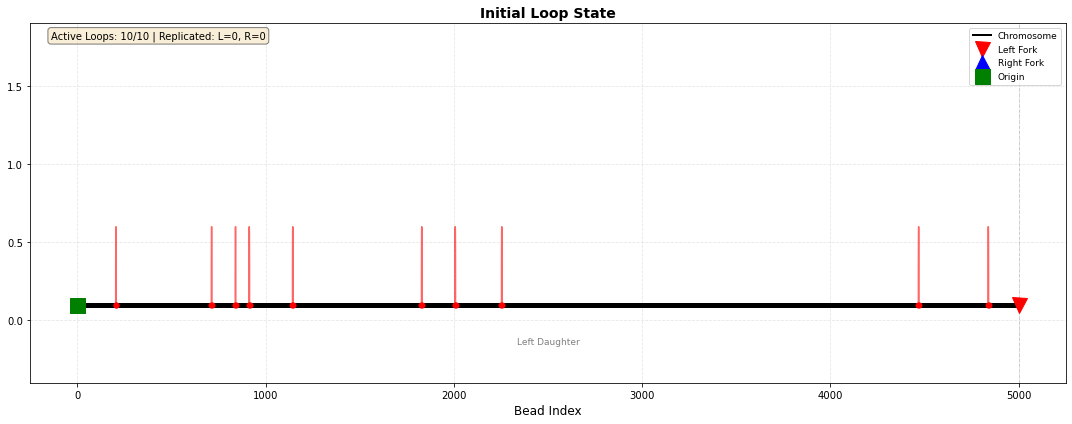


Running 20 loop extrusion steps...


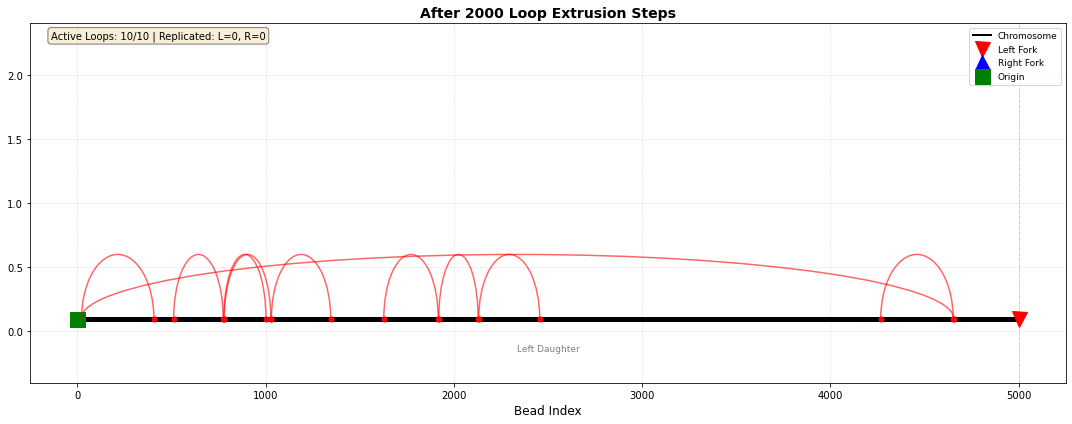

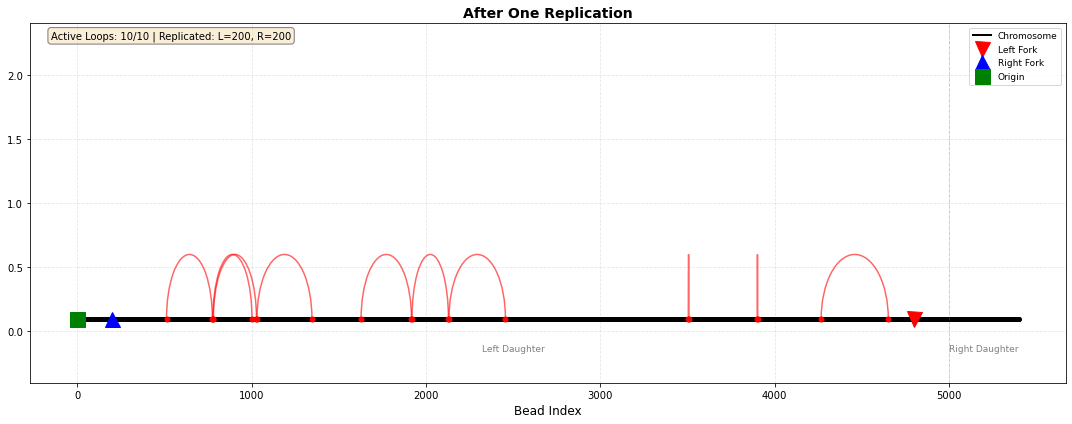

In [138]:
# Test visualization
print("Creating arc diagram visualization...")

# Create a chromosome with loops
viz_chromo = ReplicatingLoopingChromosome(
    initial_length=5000, 
    num_smc=10, 
    smc_width=1,
    random_seed=42
)

# Plot initial state
plot_arc_diagram(viz_chromo, title="Initial Loop State")
plt.show()

# Run some steps and plot again
print("\nRunning 20 loop extrusion steps...")
for i in range(200):
    # print(i)
    viz_chromo.death()
    viz_chromo.step()

plot_arc_diagram(viz_chromo, title="After 2000 Loop Extrusion Steps")
plt.show()

# Replicate and plot
for i in range(200):
    # print(i)
    viz_chromo.replicate_one_step()
plot_arc_diagram(viz_chromo, title="After One Replication")
plt.show()


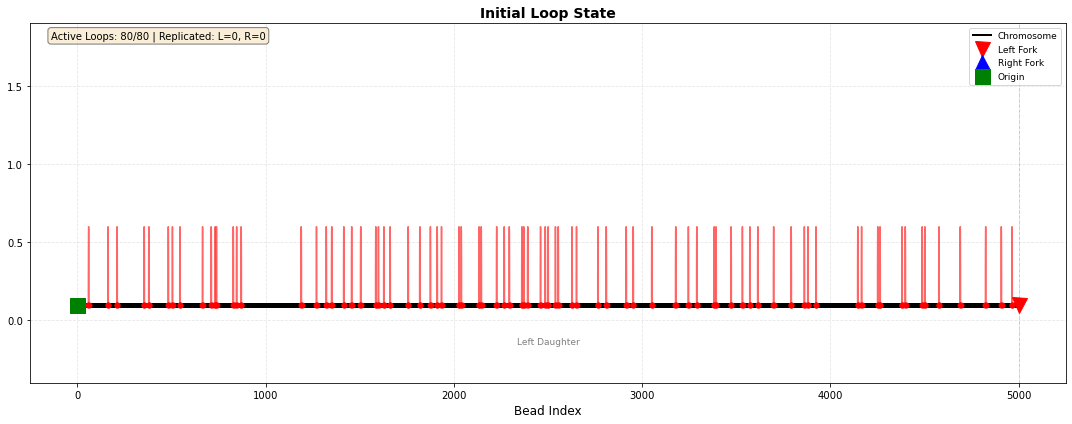

Final replication step
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrappin

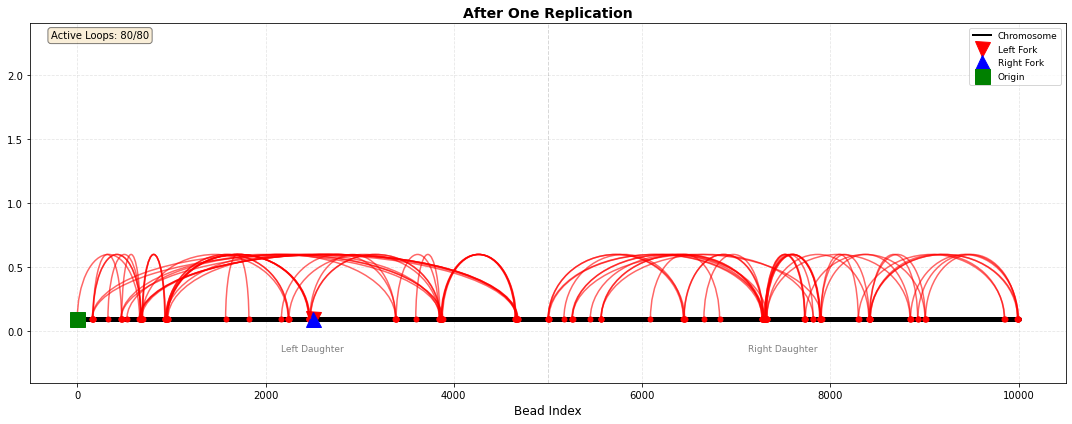

In [150]:
viz_chromo = ReplicatingLoopingChromosome(
    initial_length=5000, 
    num_smc=80, 
    smc_width=1,
    random_seed=4 
)

# Plot initial state
plot_arc_diagram(viz_chromo, title="Initial Loop State")
plt.show()

# Replicate and plot
for i in range(6000):
    viz_chromo.death()
    viz_chromo.step()
    if i < 2500:
        viz_chromo.replicate_one_step()
plot_arc_diagram(viz_chromo, title="After One Replication")
plt.show()

In [149]:
# Test validation functions and fork interactions
print("Testing fork interactions and validation...")
print("=" * 60)

test_chromo = ReplicatingLoopingChromosome(
    initial_length=50, 
    num_smc=5, 
    smc_width=1,
    random_seed=42
)

# Validate initial state
print("\nInitial state validation:")
is_valid, errors = test_chromo.validate_occupied_array()
print(f"  Occupied array valid: {is_valid}")
if errors:
    print(f"  Errors: {errors[:5]}...")  # Show first 5 errors

is_valid_pos, errors_pos = test_chromo.validate_smc_positions()
print(f"  SMC positions valid: {is_valid_pos}")
if errors_pos:
    print(f"  Errors: {errors_pos}")

# Run some steps
print("\nRunning 10 loop steps...")
for i in range(10):
    test_chromo.death()
    test_chromo.step()

# Validate after steps
print("\nAfter loop steps:")
is_valid, errors = test_chromo.validate_occupied_array()
print(f"  Occupied array valid: {is_valid}")
if errors:
    print(f"  Errors: {errors[:5]}...")

# Replicate and validate
print("\nReplicating one step...")
test_chromo.replicate_one_step()

print("\nAfter replication:")
is_valid, errors = test_chromo.validate_occupied_array()
print(f"  Occupied array valid: {is_valid}")
if errors:
    print(f"  Errors: {errors[:5]}...")

is_valid_pos, errors_pos = test_chromo.validate_smc_positions()
print(f"  SMC positions valid: {is_valid_pos}")
if errors_pos:
    print(f"  Errors: {errors_pos}")

print("\n✓ Validation test complete!")


Testing fork interactions and validation...

Initial state validation:
  Occupied array valid: True
  SMC positions valid: True

Running 10 loop steps...

After loop steps:
  Occupied array valid: True

Replicating one step...

After replication:
  Occupied array valid: True
  SMC positions valid: True

✓ Validation test complete!


Final replication step
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrapping around
fully replicated! wrappin

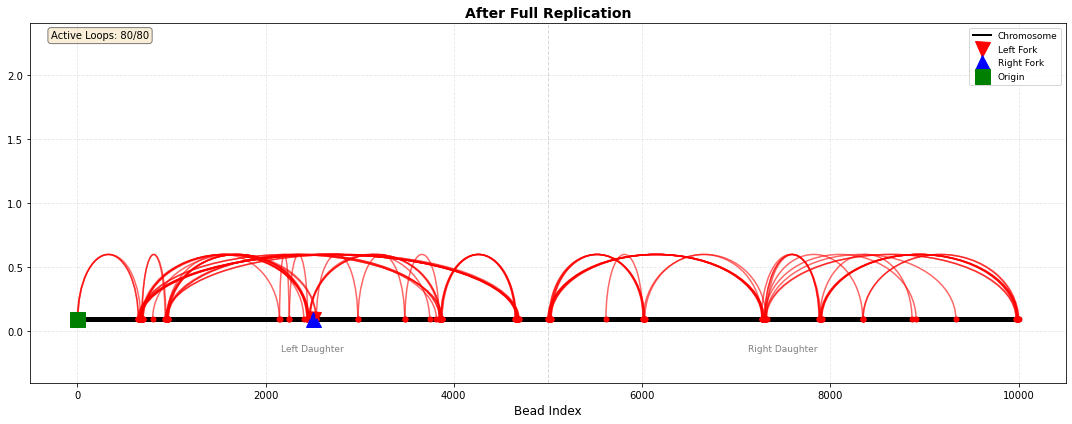

In [154]:
chromo = ReplicatingLoopingChromosome(initial_length=2000)
chromo.load_coords_from_file("dna_unreplicated.q")  # Load initial coordinates
# ... replicate and step ...
# Replicate and plot
for i in range(6000):
    chromo.death()
    chromo.step()
    if i < 1000:
        chromo.replicate_one_step()

chromo.write_coords_to_file("output_dna.q")
chromo.write_bonds_to_file("output_bonds.txt")

plot_arc_diagram(viz_chromo, title="After Full Replication")
plt.show()